# EDA

### Wczytanie danych

In [15]:
import os
from pathlib import Path
from typing import Optional

data_path: Path = Path("data")
labels_path: Path = data_path / Path("label/")
frames_path: Path = data_path / Path("image/")
data: dict[str, list[str]] = dict()
frames: dict[str, int] = dict()

emotion_mapper: dict[int, str] = {
    0: "neutral",
    1: "anger",
    2: "contempt",
    3: "disgust",
    4: "fear",
    5: "happy",
    6: "sadness",
    7: "surprise",
}

def get_emotion_from_clip(path: str) -> Optional[float]:
    label_files = os.listdir(path)
    assert len(label_files) <= 1
    if label_files:
        with open(os.path.join(path, label_files[0]) , "r") as file:
            value = float(file.readline())
        return value
    return None

# wczytanie emocji poszczególnych osób

for person in os.listdir(labels_path):
    data[person] = []
    person_path = os.path.join(labels_path, person)
    for clip in os.listdir(person_path):
        emotion_label = get_emotion_from_clip(os.path.join(person_path, clip))
        if emotion_label is not None:
            data[person].append(emotion_label)

# zliczanie klatek dla poszczególnych osób

for person in os.listdir(frames_path):
    person_path = os.path.join(frames_path, person)
    frames[person] = 0
    for clip in os.listdir(person_path):
        if clip.startswith("0"):
            frames[person] += len(
                os.listdir(os.path.join(person_path, clip))
            )


data["S096"], frames["S096"]

([5.0, 3.0, 7.0], 36)

### Rozkład emocji w zbiorze danych

In [16]:
# lista wszystkich wykrytych emocji

flat_data = sum(list(data.values()), [])
len(flat_data)

327

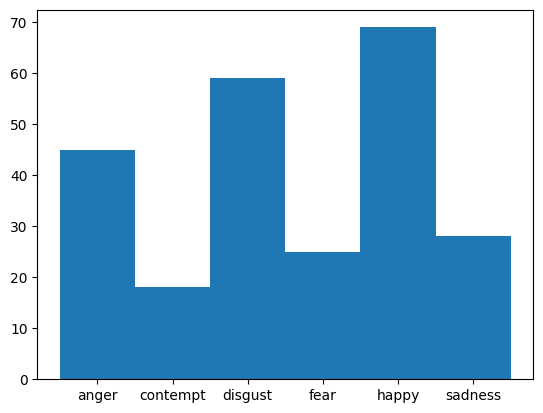

In [17]:
import matplotlib.pyplot as plt
import numpy as np

_ = plt.hist(sorted([emotion_mapper[x] for x in flat_data]), bins=np.arange(len(set(flat_data)))-0.5)

### Rozkład liczby klatek dla poszególnych osób

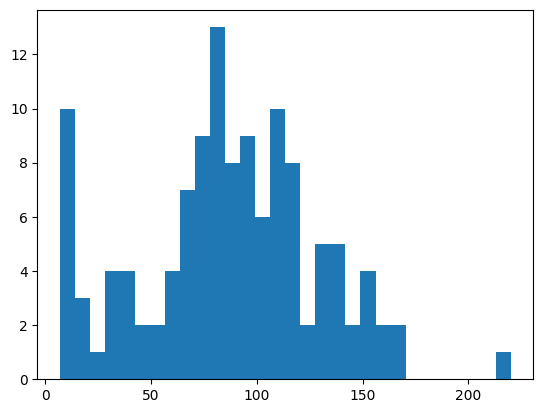

In [18]:
flat_frames: list[int] = frames.values()
_ = plt.hist(flat_frames, bins=30)

In [19]:
print(f"Maksymalna liczba klatek na osobę: {max(flat_frames)}, minimalna liczba klatek na osobę: {min(flat_frames)}.")

Maksymalna liczba klatek na osobę: 220, minimalna liczba klatek na osobę: 7.


### Przygotownie zbioru danych:

Przygotowując zbiór danych założyliśmy podział względem osób, a nie klipów, czyli jeśli ujęcia danej osoby znajdują się w zbiorze treningowym, to nie wystąpią już w walidacyjnym (i na odwrót). Takie złożenie powinno naszym zdaniem dać rzetelniejsze wyniki. 


In [20]:
import json
from dataset import make_dataset


split_path = Path("split.json")
with split_path.open() as file:
    split_dict = json.load(file)

train_dataset = make_dataset(root_path=data_path, people_names=split_dict["train"])
val_dataset = make_dataset(root_path=data_path, people_names=split_dict["val"])

total = len(train_dataset) + len(val_dataset)

print(
    f"Podział train/val: "
    f"{len(train_dataset)}/{len(val_dataset)} | " 
    f"{len(train_dataset)/total:.2f}/{len(val_dataset)/total:.2f}"
)

Podział train/val: 1363/579 | 0.70/0.30


### Rozkład emocji względem klatek w przygotowanym zbiorze danych:

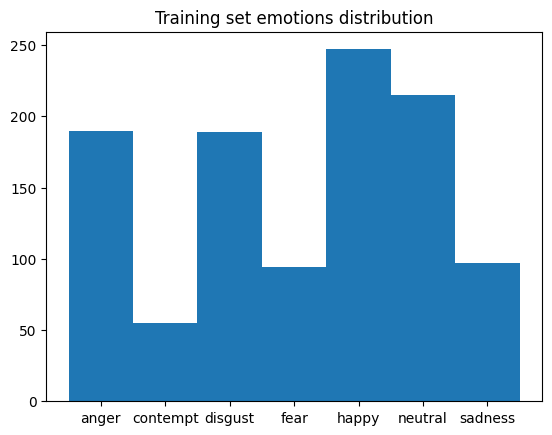

In [21]:
import torch

from collections import defaultdict
from typing import TYPE_CHECKING


def plot_emotions_distribution(dataset: torch.utils.data.Dataset, part: str):
    emotions = []
    for _, y in dataset:
        emotions.append(y.item())
    plt.title(f"{part} set emotions distribution")
    plt.hist(sorted([emotion_mapper[x] for x in emotions]), bins=np.arange(len(set(emotions)))-0.5)

plot_emotions_distribution(train_dataset, "Training")

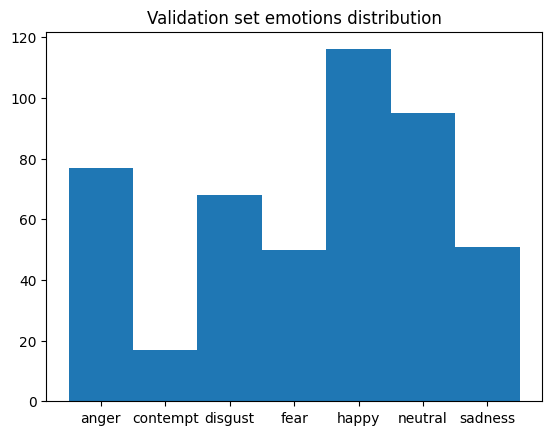

In [22]:
plot_emotions_distribution(val_dataset, "Validation")